In [1]:
%matplotlib inline


# Planetesimal Without a Core

This example shows step by step how to set up and run a model of a cooling
planetesimal without a core. This example uses constant
material properties in the mantle, see [Murphy Quinlan et al. (2021)](https://doi.org/10.1029/2020JE006726) and references therein.

While the material properties used in this example are suitable for modelling
the olivine mantle of a differentiated body, the model set-up may be useful
for modelling undifferentiated meteorite parent bodies with appropriate
thermal properties.

This model set-up also allows for comparison to an analytical solution for
conductive cooling in a sphere (see [Murphy Quinlan et al. (2021)](https://doi.org/10.1029/2020JE006726)).

First we import the required `pytesimal` modules. To allow this
example to run without the package installed, we import these
modules from the `context.py` script, which adds the package
directory to the python path. This isn't required once the
package is installed; instead modules can be loaded with
`import pytesimal.numerical_methods` etc.

As we're setting this up step-by-step instead of using the
`pytesimal.quick_workflow` module, we need to import a
selection of modules:



In [2]:
from context import setup_functions
from context import load_plot_save
from context import numerical_methods
from context import analysis
from context import core_function
from context import mantle_properties

Instead of creating and loading a parameter file, we're going to
define variables here. The values match those of the constant
thermal properties case in Murphy Quinlan et al. (2021),
except for the `core_size_factor` value:



In [3]:
timestep = 1E11  # s
r_planet = 250_000.0  # m
reg_fraction = 0.032  # fraction of r_planet
max_time = 400  # Myr
temp_core_melting = 1200.0  # K
core_cp = 850.0  # J/(kg K)
core_density = 7800.0  # kg/m^3
temp_init = 1600.0  # K
temp_surface = 250.0  # K
core_temp_init = 1600.0  # K
core_latent_heat = 270_000.0  # J/kg
kappa_reg = 5e-8  # m^2/s
dr = 1000.0  # m

As we want to model an undifferentiated body, we don't want to include
a core in our model set up. Because we wanted it to be easy to swap
between different model set-ups, the `numerical_methods.discretisation()`
function still requires a core object to be instantiated. When the boundary
conditions are set up correctly, the core object does not interact with
the mantle and does not influence the cooling. Setting `core_size_factor=0`
can lead to scalar overflow errors, which can be avoided by setting
`core_size_factor` to a small, non-zero number that is smaller than the grid
spacing (so the core_temperature_array has dimension 0 along radius):



In [4]:
core_size_factor = 0.001

For this example, we won't save any outputs. If you're working
on your local machine, you can specify the folder you want to
save your outputs to, and check that this folder exists on your
machine (if it doesn't, a folder will be created):

    folder = 'workflow'
    load_plot_save.check_folder_exists(folder)

This folder can also be specified in the parameters file.
Any variable loaded from the parameters file can be
overwritten before the model runs, which is useful if looping over
a parameter space.

The `setup_functions.set_up()` function creates empty arrays to
be filled with resulting temperatures:



In [5]:
(r_core,
 radii,
 core_radii,
 reg_thickness,
 where_regolith,
 times,
 mantle_temperature_array,
 core_temperature_array) = setup_functions.set_up(timestep,
                                                            r_planet,
                                                            core_size_factor,
                                                            reg_fraction,
                                                            max_time,
                                                            dr)

# We define an empty list of latent heat
latent = []

We can check that our "no-core" set-up has worked:



In [6]:
print(core_temperature_array.shape)

(0, 126229)


Next, we instantiate the core object. As explained previously,
this model set up does not include a core, but in order to make
the code as modular as possible, a core object still needs to be passed
in to the main timestepping function, `numerical_methods.discretisation`.
We've just copied across the default arguments for convenience:



In [7]:
core_values = core_function.IsothermalEutecticCore(
    initial_temperature=core_temp_init,
    melting_temperature=temp_core_melting,
    outer_r=r_core,
    inner_r=0,
    rho=core_density,
    cp=core_cp,
    core_latent_heat=core_latent_heat)

Then we define the mantle properties. The default is to have constant
values, so we don't require any arguments for this example:



In [8]:
(mantle_conductivity,
 mantle_heatcap,
 mantle_density) = mantle_properties.set_up_mantle_properties()

You can check (or change) the value of these properties after they've been
set up using one of the `MantleProperties` methods:



In [9]:
print(mantle_conductivity.getk())

3.0


If temperature dependent properties are used, temperature can be passed in
as an argument to return the value at that temperature.

We need to set up the boundary conditions for the mantle. For this example,
we're using fixed temperature boundary conditions at the
surface, and a zero-flux condition at the bottom to ensure symmetry.



In [10]:
top_mantle_bc = numerical_methods.surface_dirichlet_bc
bottom_mantle_bc = numerical_methods.cmb_neumann_bc

# Now we let the temperature inside the planestesimal evolve. This is the
# slowest part of the code, because it has to iterate over all radii and
# time.
# This will take a minute or two!
# Note that this function call is the exact same as in the default constant
# and variable cases that included a core.

(mantle_temperature_array,
 core_temperature_array,
 latent,
 ) = numerical_methods.discretisation(
    core_values,
    latent,
    temp_init,
    core_temp_init,
    top_mantle_bc,
    bottom_mantle_bc,
    temp_surface,
    mantle_temperature_array,
    dr,
    core_temperature_array,
    timestep,
    r_core,
    radii,
    times,
    where_regolith,
    kappa_reg,
    mantle_conductivity,
    mantle_heatcap,
    mantle_density)

This function fills the empty arrays produced by
`setup_functions.set_up()` with calculated temperatures.

Our next step is to calculate cooling rates for the body. Usually, we
calculate cooling rates for the mantle and the core in the same way.
As the core temperature array is empty, but we still need a
`core_cooling_rates` array to pass to our plotting function, we just set
`core_cooling_rates = core_temperature_array` to save time computing a
meaningless empty array:



In [11]:
mantle_cooling_rates = analysis.cooling_rate(mantle_temperature_array, timestep)
core_cooling_rates = core_temperature_array

To get an overview of the cooling history of the body, it's very useful
to plot the temperatures and cooling rates as a heatmap through time.
In order to plot the results, we need to define a figure height and width,
then call `load_plot_save.plot_temperature_history()`,
`load_plot_save.plot_coolingrate_history()` or `load_plot_save.two_in_one()`.
These functions convert the cooling rate from K/timestep to K/Myr to make
the results more human-readable.



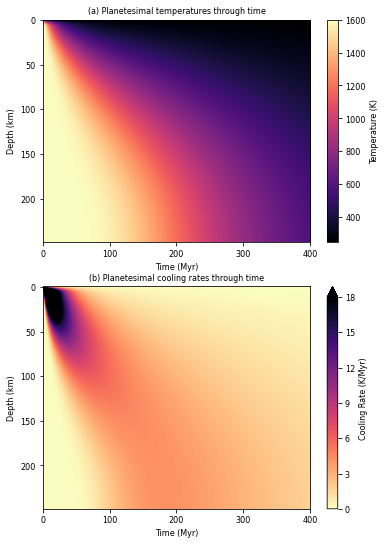

In [12]:
fig_w = 6
fig_h = 9

load_plot_save.two_in_one(
    fig_w,
    fig_h,
    mantle_temperature_array,
    core_temperature_array,
    mantle_cooling_rates,
    core_cooling_rates,)

Results can be saved in the same way as for the constant and variable
properties examples.

